# Advanced Lane Detection

Thanks for Udacity chaps for bringing up Self-Driving Car Nano Degree. This article gives short summary about the project.

## Introduction

Goal of the project is to detect lane lines from given videos and annotate lane lines on video stream and measure lane line curvature and car's offset from the lane center.


Project can be divided into following steps
* Analyse given videos and come up with the plan to create lane line detection algorithm
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


[//]: # (Image References)
[image1]: ./illustrations/project_video.mp4_straight_lane.jpg "project_video.mp4: straight lane portion"
[image2]: ./illustrations/project_video.mp4_border_of_dark_and_bright_road.jpg "project_video.mp4: Change from dark road to bright road."
[image3]: ./illustrations/project_video.mp4_curve.jpg "project_video.mp3: Curve:



[//]: # (Video References)
[video1]: ./video.mp4 "Final result: Car driving autonomously"

[//]: # (Article References)
[1]: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9



## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

### Writeup / README

#### 1. Provide a Writeup 
This report is a writeup




[//]: # (Image References)
[image1]: ./illustrations/project_video.mp4_straight_lane.jpg "project_video.mp4: straight lane portion"
[image2]: ./illustrations/project_video.mp4_border_of_dark_and_bright_road.jpg "project_video.mp4: Change from dark road to bright road."
[image3]: ./illustrations/project_video.mp4_curve.jpg "project_video.mp3: Curve"



## Video Analysis

In this section i give brief summary and analysis of three given videos.

### 1. 'project_video.mp4'

This video is mandatory to meet project specification.

Video consist of seemingly quite high contrast lane lines. 
![straight lane portion][image1]
![curve][image3]

There is one place where road contrast changes significantly.

![Change from dark road to bright road.][image2]


### 2. 'challenge_video.mp4'

This video is optional challenge.

### 3. 'harder_challenge_video.mp4'

This video is optional challenge.



In [3]:
# In this code cell i show basic statistics of video and video will be played
%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
clip1 = VideoFileClip("project_video.mp4")
print("Duration of clip: ", clip1.duration)
print("FPS of clip:, ", clip1.fps)
i_frame_ms = 1 / clip1.fps * 1000  # Interval between frames in milliseconds
print("Interval between frames {}ms".format(i_frame_ms))
frame_iter = clip1.iter_frames()
 
for frame in frame_iter:
    #frame = clip1.get_frame(i)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imshow('image', frame)
    if cv2.waitKey(int(i_frame_ms)) & 0xFF == ord('q'):
        break
cv2.waitKey(5000)
cv2.destroyAllWindows()

Duration of clip:  50.4
FPS of clip:,  25.0
Interval between frames 40.0ms


In [1]:
# In this code cell i'll take snapshot of video to show features of video.

%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_file = "project_video.mp4"
clip1 = VideoFileClip(video_file)
save_path = "./illustrations/"
capture_location = ((15., "_straight_lane"), (21.,"_border_of_dark_and_bright_road"), (27., "_curve"))
for loc, name in capture_location:
    frame = clip1.get_frame(loc)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path+video_file+name+".jpg", frame)

In [2]:
# In this code cell i'll take snapshot of video to show features of video.

%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_file = "challenge_video.mp4"
clip1 = VideoFileClip(video_file)
save_path = "./illustrations/"
capture_location = ((1., "_tarmac_edge_separates"), (4.,"_shadow"), (14., "_tarmac_edge_joins"))
for loc, name in capture_location:
    frame = clip1.get_frame(loc)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path+video_file+name+".jpg", frame)

In [3]:
# In this code cell i'll take snapshot of harder challenge video to show features of video.

%matplotlib inline
# Import everything needed to edit/save/watch video clips
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_file = "harder_challenge_video.mp4"
clip1 = VideoFileClip(video_file)
save_path = "./illustrations/"
capture_location = ((3.5, "_yellow_line_occlusion"), (10, "_white_line_occlusion"), (34.,"_over_exposed"), (41., "_right_line_not_in_view"))
for loc, name in capture_location:
    frame = clip1.get_frame(loc)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path+video_file+name+".jpg", frame)

## Camera calibration

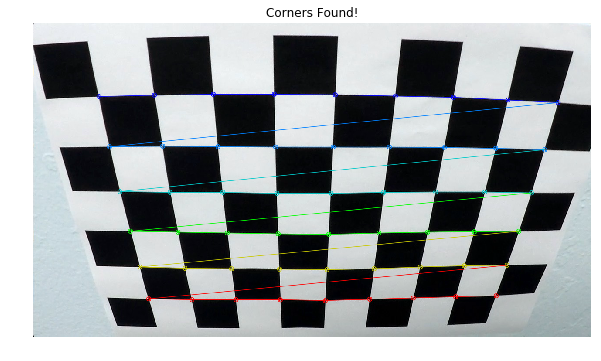

In [4]:
# Find corners

%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tqdm

# define criteria to stop corner subpixel search
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Number of inside corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

img = cv2.imread("./camera_cal/calibration2.jpg")
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Find the chess board corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
if ret:
    cv2.cornerSubPix(gray,corners,(11,11),(-1,-1), criteria)
    imgpoints.append(corners)

    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners,ret)
    plt.figure(figsize=(10,10))
    
    plt.title("Corners Found!")
    plt.axis('off')
    plt.imshow(img)
    plt.imsave("./illustrations/calib_corners_found.jpg", img)
else:
    print("No corners found.")

Finding corners:   0%|          | 0/20 [00:00<?, ?it/s]

Finding corners:   5%|▌         | 1/20 [00:01<00:25,  1.35s/it]

Finding corners:  10%|█         | 2/20 [00:01<00:20,  1.12s/it]

Finding corners:  15%|█▌        | 3/20 [00:02<00:17,  1.01s/it]

Finding corners:  20%|██        | 4/20 [00:02<00:11,  1.36it/s]

Finding corners:  25%|██▌       | 5/20 [00:03<00:09,  1.55it/s]

Finding corners:  30%|███       | 6/20 [00:03<00:08,  1.62it/s]

Finding corners:  35%|███▌      | 7/20 [00:04<00:07,  1.72it/s]

Finding corners:  40%|████      | 8/20 [00:04<00:06,  1.79it/s]

Finding corners:  45%|████▌     | 9/20 [00:05<00:05,  2.06it/s]

Finding corners:  50%|█████     | 10/20 [00:05<00:04,  2.02it/s]

Finding corners:  55%|█████▌    | 11/20 [00:06<00:05,  1.60it/s]

Finding corners:  60%|██████    | 12/20 [00:07<00:04,  1.69it/s]

Finding corners:  65%|██████▌   | 13/20 [00:07<00:04,  1.60it/s]

Finding corners:  70%|███████   | 14/20 [00:08<00:03,  1.75it/s]

Finding corners:  75%|███████▌  | 15/20 [00:08<00:02,  2.00it/s]

Finding corners:  80%|████████  | 16/20 [00:09<00:02,  1.88it/s]

Finding corners:  85%|████████▌ | 17/20 [00:09<00:01,  2.47it/s]

Finding corners:  90%|█████████ | 18/20 [00:09<00:00,  2.06it/s]

Finding corners:  95%|█████████▌| 19/20 [00:10<00:00,  2.09it/s]

Finding corners: 100%|██████████| 20/20 [00:10<00:00,  2.10it/s]

Successfully read corners of 17/20 images.


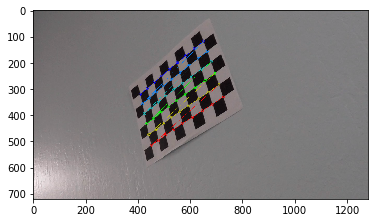

In [3]:
# Camera calibration
# http://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/bf149677-e05e-4813-a6ea-5fe76021516a
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a30f45cb-c1c0-482c-8e78-a26604841ec0

%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import tqdm

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Number of inside corners
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('./camera_cal/*.jpg')
counter = 0
for fname in tqdm.tqdm(images, desc="Finding corners"):
    #print("reading: ", fname, end='')
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny))
    # If found, add object points, image points (after refining them)
    if ret:
        counter += 1
        objpoints.append(objp)

        cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners,ret)
        #cv2.imshow('img',img)
        plt.imshow(img)
        #cv2.waitKey(500)

print("Successfully read corners of {}/{} images.".format(counter, len(images)))
#cv2.destroyAllWindows()

In [4]:
# Calculate calibration coefficients
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

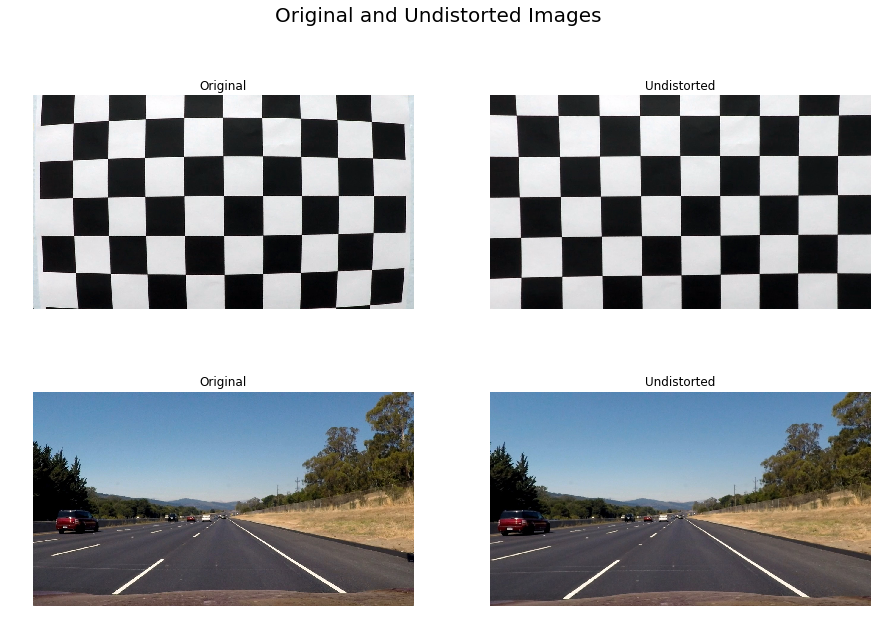

In [7]:
# Undistort
# http://docs.opencv.org/trunk/dc/dbb/tutorial_py_calibration.html
%matplotlib inline
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

img = cv2.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, None)

img2 = cv2.imread('./test_images/straight_lines2.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
dst2 = cv2.undistort(img2, mtx, dist, None, None)

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Original and Undistorted Images", fontsize=20)

a = fig.add_subplot(2, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(img)
a = fig.add_subplot(2, 2, 2)
plt.title("Undistorted")
plt.axis('off')
plt.imshow(dst)

a = fig.add_subplot(2, 2, 3)
plt.axis('off')
plt.title("Original")
plt.imshow(img2)
a = fig.add_subplot(2, 2, 4)
plt.title("Undistorted")
plt.axis('off')
plt.imshow(dst2)

plt.savefig("./illustrations/calib_original_and_undistorted.jpg")

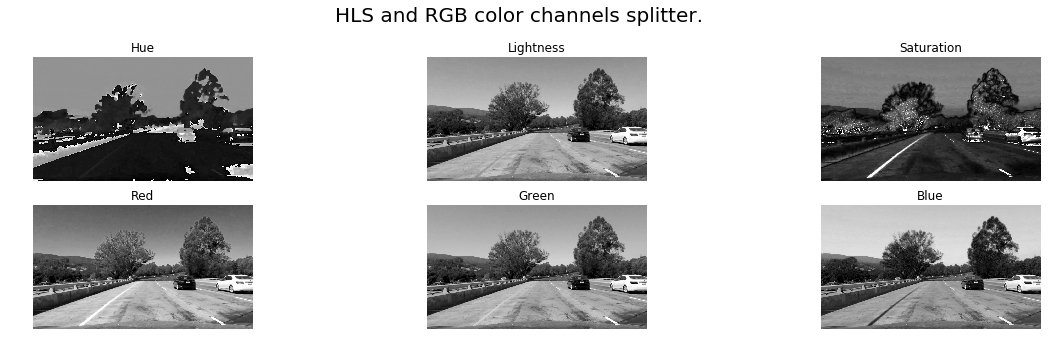

In [8]:
# Test out HSL and different color transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = cv2.imread('./test_images/test1.jpg')
img = cv2.undistort(img, mtx, dist, None, None)

hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)


H, L, S = hls[:,:,0], hls[:,:,1], hls[:,:,2]
B, G, R = img[:,:,0], img[:,:,1], img[:,:,2]

fig = plt.figure(figsize=(20, 5))
fig.suptitle("HLS and RGB color channels splitter.", fontsize=20, y=1.02)

for i, x in enumerate(zip((H, L, S, R, G, B), ("Hue", "Lightness", "Saturation", "Red", "Green", "Blue"))):
    im, title = x
    a = fig.add_subplot(2, 3, i+1)
    plt.axis('off')
    plt.title(title)
    plt.imshow(im, cmap='gray')
    
plt.savefig("./illustrations/color_hls_rgb_channles_splitted.jpg")

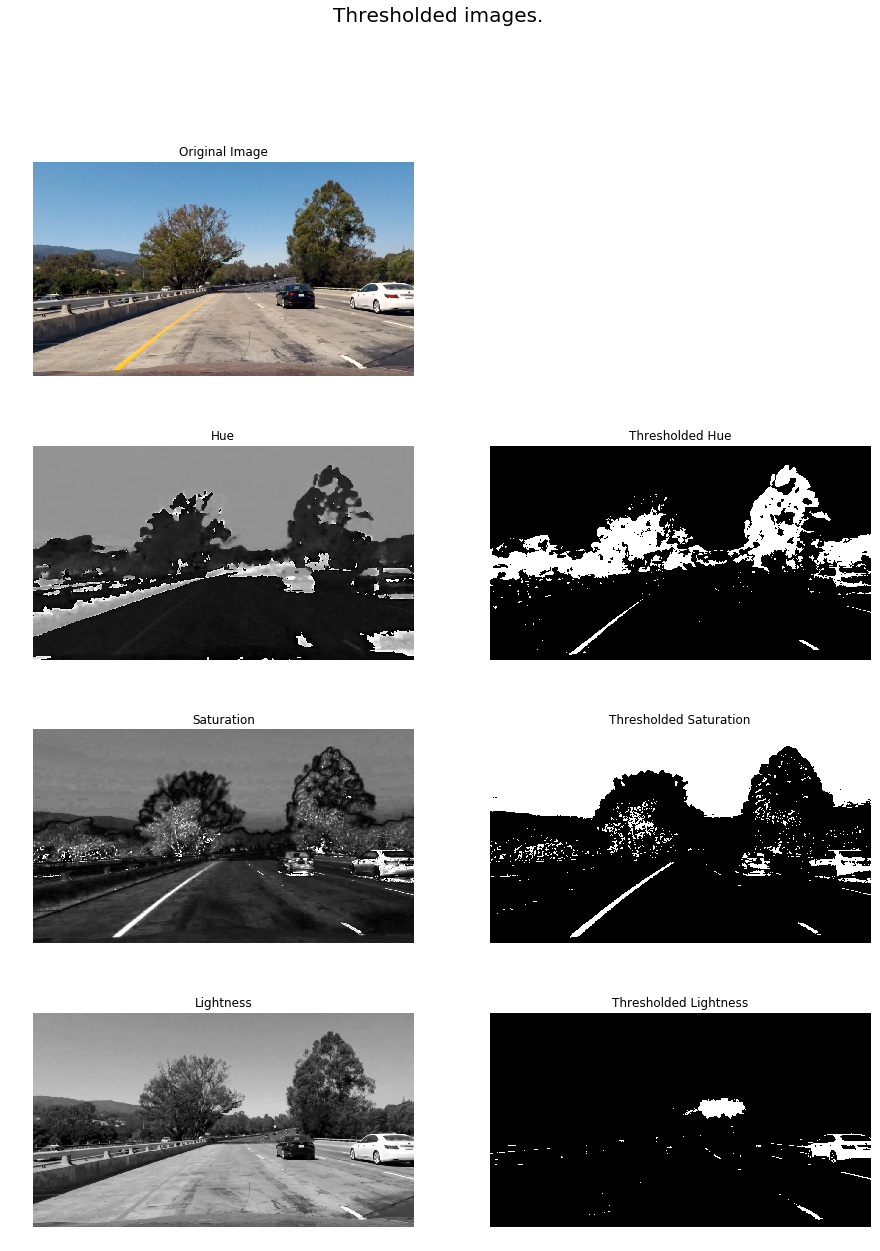

In [38]:
# Test out HSL thresholding
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

img = cv2.imread('./test_images/test1.jpg')
img = cv2.undistort(img, mtx, dist, None, None)
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

# Detect and threshold yellow line on Hue-Channel
thresh = (20, 70)
gray = H
binary_yh = np.zeros_like(gray)
binary_yh[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# Detect and threshold yellow and white line on Saturation-Channel
thresh = (110, 255)
gray = S
binary_yws = np.zeros_like(gray)
binary_yws[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# Detect and threshold white line on Lightness-Channel
thresh = (200, 255)
gray = L
binary_wl = np.zeros_like(gray)
binary_wl[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# Image, Name, cmap
images = [#[rgb,        "Original",               None],
          [H,          "Hue",                    "gray"],
          [binary_yh,  "Thresholded Hue",        "gray"],
          [S,          "Saturation",             "gray"],
          [binary_yws, "Thresholded Saturation", "gray"],
          [L,          "Lightness",              "gray"],
          [binary_wl,  "Thresholded Lightness",  "gray"]]

fig = plt.figure(figsize=(15, 20))
fig.suptitle("Thresholded images.", fontsize=20)

# Plot RGB Image first
a = fig.add_subplot(4, 2, 1)
plt.axis('off')
plt.title("Original Image")
plt.imshow(rgb)

for i, t in enumerate(images):
    im, name, cmap = t
    a = fig.add_subplot(4, 2, i+3)
    plt.axis('off')
    plt.title(name)
    plt.imshow(im, cmap=cmap)
    
plt.savefig("./illustrations/color_thresholded.jpg")

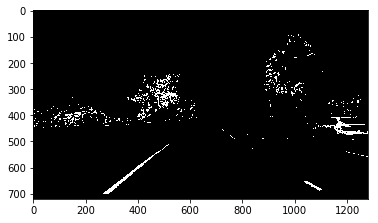

In [10]:
# Find yellow lines
binary_yellow = np.zeros_like(gray)
binary_yellow[(binary_yws == 1)& (binary_yh == 1)] = 1
plt.imshow(binary_yellow, cmap="gray")

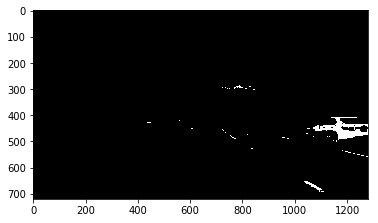

In [11]:
# Find white lines
binary_white = np.zeros_like(gray)
binary_white[(binary_yws == 1)& (binary_wl == 1)] = 1
#binary_white = binary_yws + binary_wl
plt.imshow(binary_white, cmap="gray")

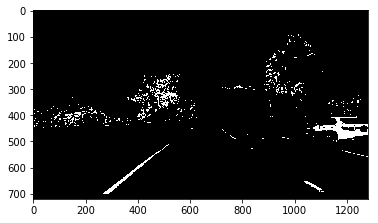

In [12]:
# Combine Yellow and white lines
binary_both = np.zeros_like(gray)
binary_both[(binary_yellow==1)|(binary_white==1)]=1
plt.imshow(binary_both, cmap="gray")

In [10]:
# In this code cell i show color thresholded video
# Import everything needed to edit/save/watch video clips
from LaneFinder.colorthreshold import color_threshold as ct
import cv2
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
%matplotlib inline

#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("challenge_video.mp4")
print("Duration of clip: ", clip1.duration)
print("FPS of clip:, ", clip1.fps)
i_frame_ms = 1 / clip1.fps * 1000  # Interval between frames in milliseconds
print("Interval between frames {}ms".format(i_frame_ms))
frame_iter = clip1.iter_frames()
 
for frame in frame_iter:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = ct(frame).astype(dtype=np.float32)
    cv2.imshow('image', frame)
    if cv2.waitKey(int(i_frame_ms)) & 0xFF == ord('q'):
        break

#frame = clip1.get_frame(1)
#frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
#frame = ct(frame).astype(dtype=np.float32)
#cv2.imshow('image', frame)
cv2.waitKey(5000)
cv2.destroyAllWindows()

Duration of clip:  16.15
FPS of clip:,  29.97002997002997
Interval between frames 33.36666666666667ms


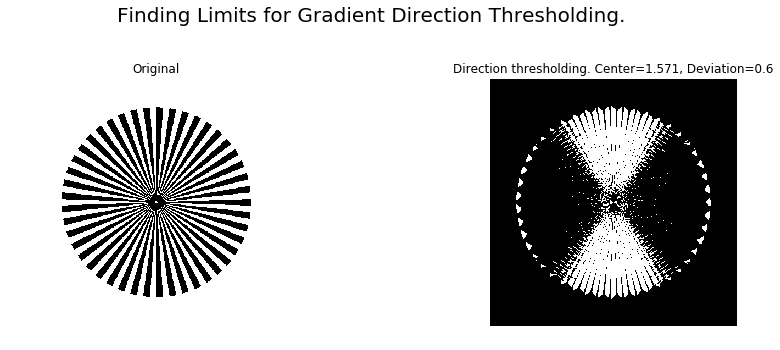

In [39]:
from LaneFinder.gradient_threshold import *
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('./LaneFinder/test_images/sector_45_cycles.jpg')

#img = cv2.imread('./test_images/600px-Siemens_star.svg.png')
#img = cv2.undistort(img, mtx, dist, None, None)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
ksize=5
#mu = 1.5
mu = np.pi / 2
dev = 0.6
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(mu-dev, mu+dev))
# plt.imshow(dir_binary, cmap="gray")

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Finding Limits for Gradient Direction Thresholding.", fontsize=20)

a = fig.add_subplot(2, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(gray, cmap='gray')
a = fig.add_subplot(2, 2, 2)
plt.title("Direction thresholding. Center={:.3f}, Deviation={}".format(mu, dev))
plt.axis('off')
plt.imshow(dir_binary, cmap='gray')

plt.savefig("./illustrations/grad_direction_thresholding_sectors.jpg")

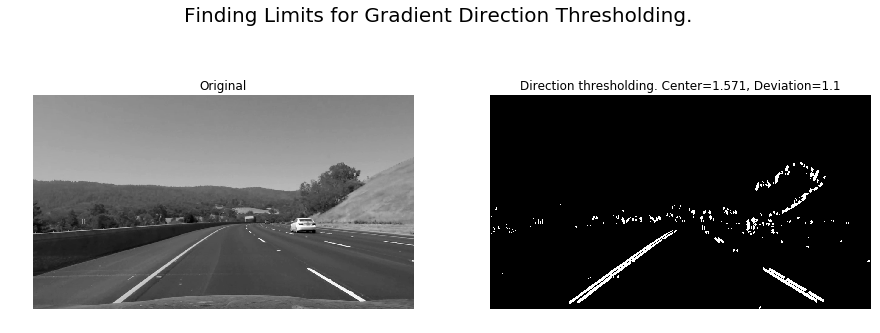

In [53]:
from LaneFinder.gradient_threshold import *
import matplotlib.image as mpimg
%matplotlib inline

img = mpimg.imread('./illustrations/project_video.mp4_curve.jpg')

#img = cv2.imread('./test_images/600px-Siemens_star.svg.png')
#img = cv2.undistort(img, mtx, dist, None, None)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.undistort(gray, mtx, dist, None, None)
ksize=13
#mu = 1.5
mu = np.pi / 2
dev = 1.1
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(mu-dev, mu+dev))

mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))

combined = np.zeros_like(dir_binary)
combined[((mag_binary == 1) & (dir_binary == 1))] = 1

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Finding Limits for Gradient Direction Thresholding.", fontsize=20)

a = fig.add_subplot(2, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(gray, cmap='gray')
a = fig.add_subplot(2, 2, 2)
plt.title("Direction thresholding. Center={:.3f}, Deviation={}".format(mu, dev))
plt.axis('off')
plt.imshow(combined, cmap='gray')

plt.savefig("./illustrations/grad_direction_thresholding_sectors.jpg")

## Warping the image

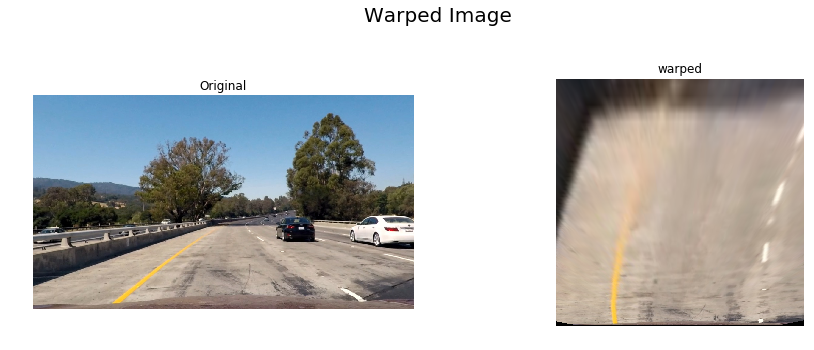

In [81]:
image = cv2.imread('./test_images/test1.jpg')
image = cv2.undistort(image, mtx, dist, None, None)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#image_size = (image.shape[1], image.shape[0])
image_size = (480, 480)
# TR, BR, BL, TL
src = np.array([[685, 445],
                [1030, 670],
                [278, 670],
                [599, 445]], dtype=np.float32)

dst = np.array([[380, 100],
                [380, 470],
                [100, 470],
                [100, 100]], dtype=np.float32)

M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)

fig = plt.figure(figsize=(15, 10))
fig.suptitle("Warped Image", fontsize=20)

a = fig.add_subplot(2, 2, 1)
plt.axis('off')
plt.title("Original")
plt.imshow(image)
a = fig.add_subplot(2, 2, 2)
plt.axis('off')
plt.title("warped")
plt.imshow(warped)